# Sea Turtle and Marine Debris Detection Using drones

## Introduction

Automated object detection in marine environments is an essential task for wildlife monitoring and environmental protection. In particular, the ability to identify **sea turtles** and **floating debris** from aerial drone imagery enables:

- faster and more efficient field surveys,
- reduced manual inspection time,
- more consistent and scalable data collection,
- improved understanding and protection of marine ecosystems.

However, drone imagery presents significant challenges:

- turtles and debris often appear very small relative to the full image,
- environmental conditions vary greatly (reflections, waves, turbidity),
- objects of interest may be partially visible or blend into the background,
- high-resolution images (e.g., 1920×1080) cannot be fed directly into standard image classifiers.

To address these limitations, we adopt a **local classification approach**:

1. Each drone image is divided into small tiles of **192×192** pixels.
2. Each tile contains either:
   - a turtle,
   - a debris item,
   - or nothing (water only).
3. A convolutional neural network is trained to classify each tile into one of these categories.

### Why tiling?

Tiling the images provides several benefits:

- objects appear at a consistent scale across the dataset,
- the number of training samples increases significantly,
- the complex detection problem becomes a simpler supervised classification task,
- the model can later be applied over full images using a sliding-window or heatmap approach.

### What this notebook will cover

In this notebook, we will:

1. explain the tiling process and why it is necessary,
2. prepare and structure the dataset (train/validation),
3. apply data augmentation adapted to marine conditions,
4. train an EfficientNet-B0 classifier on three classes (turtle, debris, nothing),
5. visualize training curves (loss and accuracy),
6. test the model on new tiles,
7. Conclude

This workflow represents the first step toward an automated system capable of detecting sea turtles and marine debris directly from aerial drone imagery.


## Here are all the librairies we'll need in this project

In [4]:
import os
import time
import random
import shutil

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from IPython.display import HTML, display
import io, base64

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## Image Tiling

Most drone images used in this project have a high resolution (1920×1080) or (1429*767).  
At this scale, turtles and debris appear very small, sometimes covering only a few dozen pixels.  
If a full-resolution image is directly resized to 192×192 (the input size required by our model), all relevant details become too small or are lost completely.

To address this limitation, we apply **tiling**.

### What is tiling?

Tiling consists of splitting each high-resolution image into many smaller fixed-size patches (tiles).  
In our case, each tile has a size of **192×192** pixels.  
We slide a fixed window across the image, extract each tile, and save it independently.

This process ensures that:

- objects (turtles, debris) appear at a **consistent and visible scale**,
- each tile contains either:
  - a turtle,
  - a debris item,
  - or only water ("nothing"),
- we generate **many more training examples** from a single image,
- we transform the problem from large-image detection into **local classification**.

### Why do we use overlap?

If tiles are extracted with no overlap, an object sitting at the border between two tiles may be cut in half and become unrecognizable.  
To avoid this issue, we use a **30% overlap** between tiles.

This means each tile overlaps its neighbors horizontally and vertically, ensuring that:

- turtles and debris are rarely cut in half,
- more contextual information is preserved,
- the classifier becomes more robust.

### Summary of our tiling approach

- Tile size: **192×192**
- Overlap: **30% to 40%**
- Input formats: PNG/JPG
- Optional filtering: remove tiles that are too dark or too uniform
- Output: thousands of tiles ready for classification (turtle / debris / nothing)

The tiled dataset will be used in the next sections for data preparation, augmentation, training, and evaluation.


## Binary Classification: Turtle vs Nothing
In this first part, we focus only on distinguishing **sea turtles** from **empty-water tiles**.  
This allows us to validate our pipeline (tiling -> augmentation -> training -> evaluation) before extending it to multiple classes.

### Image Tiling Script

This script splits each high-resolution drone image into **192×192 tiles** with overlap.  
Tiles that are too dark or too uniform are discarded.  

In [ ]:
# -------------------------------------------------------
# 1. Paths (adapt before running)
# -------------------------------------------------------

INPUT_DIR = r"C:\Users\alial\OneDrive\Bureau\GreenAIproject\GreenAIDataset2021V2"  # raw drone images
OUTPUT_DIR = r"C:\Users\alial\OneDrive\Bureau\GreenAIproject\tilesV2"              # where tiles will be saved

os.makedirs(OUTPUT_DIR, exist_ok=True)


# -------------------------------------------------------
# 2. Tiling parameters
# -------------------------------------------------------

TILE_SIZE = 192        # final tile size
OVERLAP = 0.36         # 36% overlap between tiles
stride = int(TILE_SIZE * (1 - OVERLAP))   # effective sliding step

# Light filtering (kept weak to avoid losing too many tiles)
BRIGHTNESS_THRESHOLD = 20
MIN_VARIANCE = 50


# -------------------------------------------------------
# 3. Tile filtering function
# -------------------------------------------------------

def is_useful_tile(tile: Image.Image) -> bool:
    """
    Returns False if the tile is too dark or too uniform.
    Filtering is intentionally light to avoid discarding tiles
    that may contain small turtles or small debris.
    """
    tile_np = np.array(tile.convert("L"))  # grayscale

    # mean brightness threshold
    if tile_np.mean() < BRIGHTNESS_THRESHOLD:
        return False

    # texture variance threshold
    if tile_np.var() < MIN_VARIANCE:
        return False

    return True


# -------------------------------------------------------
# 4. Function: Create tiles from a single image
# -------------------------------------------------------

def tile_image(image_path: str) -> int:
    """
    Splits an image into 192×192 PNG tiles.
    Returns the number of saved tiles.
    """
    img = Image.open(image_path).convert("RGB")
    w, h = img.size

    base_name = os.path.splitext(os.path.basename(image_path))[0]
    saved = 0

    for y in range(0, h - TILE_SIZE + 1, stride):
        for x in range(0, w - TILE_SIZE + 1, stride):

            tile = img.crop((x, y, x + TILE_SIZE, y + TILE_SIZE))

            if not is_useful_tile(tile):
                continue

            tile_name = f"{base_name}_x{x}_y{y}.png"
            tile_path = os.path.join(OUTPUT_DIR, tile_name)
            tile.save(tile_path)

            saved += 1

    return saved


# -------------------------------------------------------
# 5. Main tiling loop
# -------------------------------------------------------

def run_tiling():
    files = [f for f in os.listdir(INPUT_DIR) if f.lower().endswith(".png")]
    total_tiles = 0

    print("----- STARTING TILING -----\n")

    for f in files:
        img_path = os.path.join(INPUT_DIR, f)
        n = tile_image(img_path)
        total_tiles += n
        print(f"{f} → {n} tiles saved")

    print("\n----- TILING COMPLETE -----")
    print("Images processed :", len(files))
    print("Total tiles generated :", total_tiles)
    print("Tiles saved in :", OUTPUT_DIR)


# Run the tiling script
run_tiling()

#### Note on the Tiling Step

The tiling script shown in this notebook is **not executed here**, as the tiling process was performed beforehand.  
Since tiling large drone images generates thousands of 192×192 tiles, running it directly inside the notebook would be time-consuming and unnecessary.

The code is included **for documentation and reproducibility**, but the dataset used in the following sections was already pre-generated.


#### Manual Selection of Turtle and "Nothing" Tiles

After generating all tiles from the drone images, the next step is to create the binary dataset (**turtle** vs **nothing**).

Since the tiling process extracts every possible region of the image, most tiles contain only water. Therefore:

- We manually inspect the generated tiles.
- We select all tiles that contain a **turtle**.
- Then, to avoid class imbalance, we select approximately the **same number** of tiles that contain **nothing** (only water).


Here is an example of what the manual selection process looks like in practice.

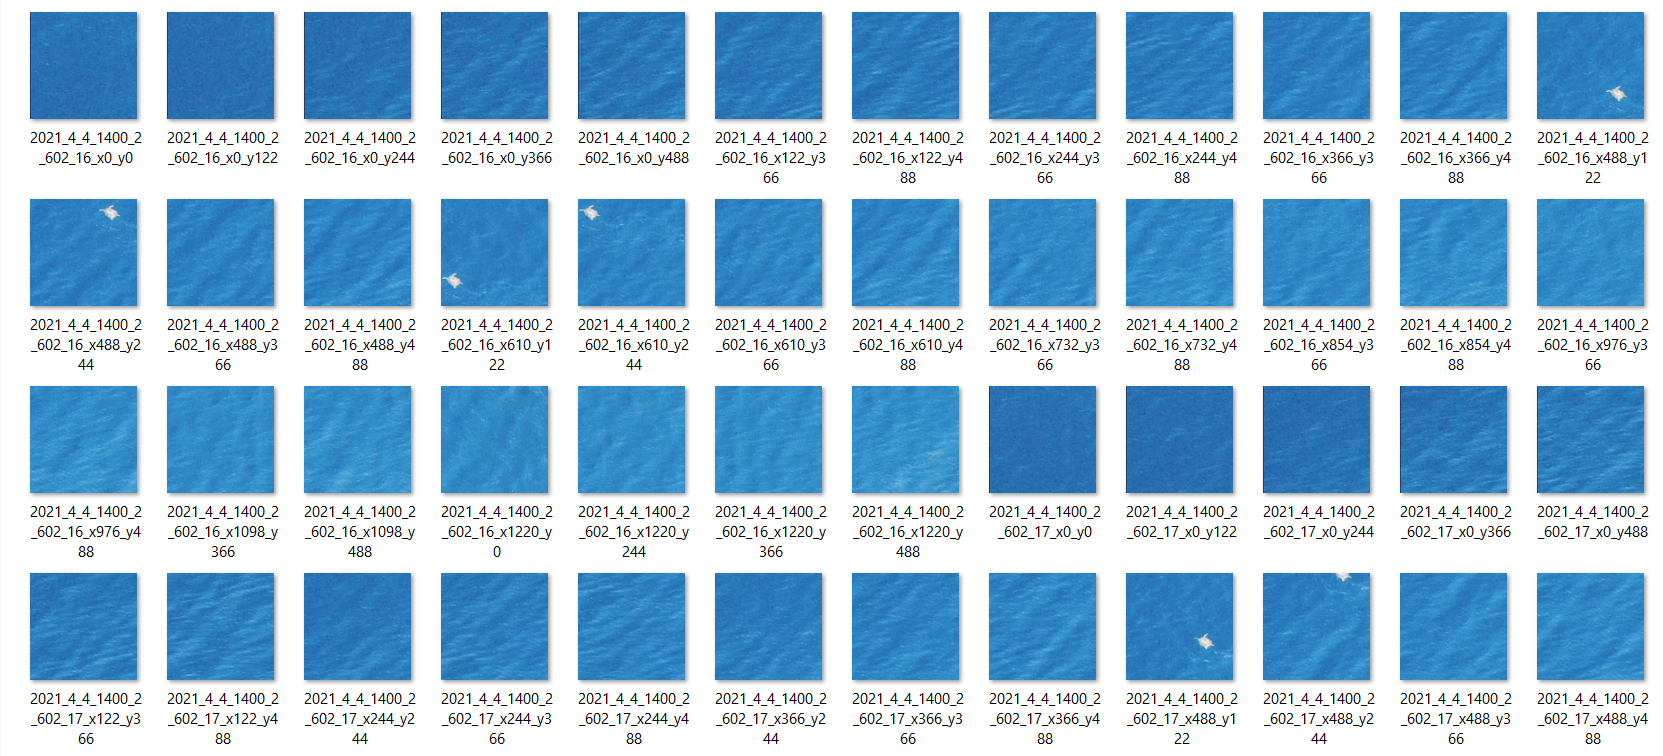

In [2]:
Image("im1.png")

This results in a clean and balanced binary dataset that will be used to train the first model (turtle vs nothing).

### DataSet Preparation

Train/Validation Split for Binary Classification

This cell creates a clean dataset structure for the binary classification task:  
**turtle vs nothing**.  
It automatically separates images into training and validation sets.


In [2]:
# -------------------------------------------------------
# 1. Configuration (adapt paths if needed)
# -------------------------------------------------------

SOURCE_DIR = r"C:\Users\alial\OneDrive\Bureau\GreenAIprojectV2"   # contains: "turtle", "nothing"
OUTPUT_DIR = r"C:\Users\alial\OneDrive\Bureau\GreenAIprojectV2\dataset_binary"

CLASSES = ["turtle", "nothing"]   # binary classification
VAL_RATIO = 0.20               # 20% validation split


# -------------------------------------------------------
# 2. Create output folders
# -------------------------------------------------------

def create_folders():
    for split in ["train", "val"]:
        for cls in CLASSES:
            folder = os.path.join(OUTPUT_DIR, split, cls)
            os.makedirs(folder, exist_ok=True)


# -------------------------------------------------------
# 3. Random split function
# -------------------------------------------------------

def split_dataset():
    for cls in CLASSES:
        class_dir = os.path.join(SOURCE_DIR, cls)
        images = [f for f in os.listdir(class_dir)
                  if f.lower().endswith((".png", ".jpg", ".jpeg"))]

        random.shuffle(images)

        n_total = len(images)
        n_val = int(n_total * VAL_RATIO)

        val_images = images[:n_val]
        train_images = images[n_val:]

        print(f"\nClass '{cls}': {n_total} images → {len(train_images)} train, {len(val_images)} val")

        # Copy train images
        for img in train_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(OUTPUT_DIR, "train", cls, img)
            shutil.copy(src, dst)

        # Copy validation images
        for img in val_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(OUTPUT_DIR, "val", cls, img)
            shutil.copy(src, dst)


# -------------------------------------------------------
# 4. Run the split
# -------------------------------------------------------

create_folders()
split_dataset()

print("\nDataset ready in:", OUTPUT_DIR)



Class 'turtle': 534 images → 428 train, 106 val

Class 'nothing': 595 images → 476 train, 119 val

Dataset ready in: C:\Users\alial\OneDrive\Bureau\GreenAIprojectV2\dataset_binary


#### Dataset Directory Structure

After splitting the dataset into training and validation sets, the directory structure should look like this:

In [ ]:
dataset_binary/
│
├── train/
│   ├── turtle/
│   └── nothing/
│
└── val/
    ├── turtle/
    └── nothing/

Each folder contains the corresponding image tiles.  
This structure is automatically created by the train/validation split script and is required by **PyTorch's `ImageFolder`**.


### Training a Binary Classifier (Turtle vs Nothing)

This section trains a convolutional neural network to classify 192×192 image tiles into two categories:

- **turtle**  
- **nothing** (only water)

The workflow includes:

1. **Dataset loading**  
   The dataset is organized into `train/` and `val/` folders, following the standard `ImageFolder` structure.

2. **Data augmentation**  
   Random horizontal flips, rotations, and color variations are applied to the training images to increase robustness to lighting changes, water reflections, and drone onothingtation.

3. **Model definition**  
   A pretrained EfficientNet-B0 model is loaded, and the final classification layer is replaced by a binary output layer (`NUM_CLASSES = 2`).

4. **Training loop**  
   During each epoch, the model:
   - learns from the training set via backpropagation,
   - is evaluated on the validation set,
   - logs loss and accuracy values for monitoring.

5. **Saving the model**  
   The trained weights are saved under `turtle_classifier.pth`.

6. **Performance visualization**  
   Training and validation curves (loss & accuracy) are displayed to evaluate convergence and potential overfitting.

This model will later be used to classify tiles extracted from drone images, forming the first step of a full detection workflow.


Using device: cpu
Detected classes: ['nothing', 'turtle']
[Epoch 1/15] Train Loss: 0.5334 | Train Acc: 0.758 | Val Loss: 0.3559 | Val Acc: 0.920
[Epoch 2/15] Train Loss: 0.2247 | Train Acc: 0.952 | Val Loss: 0.1216 | Val Acc: 0.991
[Epoch 3/15] Train Loss: 0.0864 | Train Acc: 0.982 | Val Loss: 0.0462 | Val Acc: 0.996
[Epoch 4/15] Train Loss: 0.0383 | Train Acc: 0.991 | Val Loss: 0.0295 | Val Acc: 0.996
[Epoch 5/15] Train Loss: 0.0184 | Train Acc: 0.999 | Val Loss: 0.0264 | Val Acc: 0.996
[Epoch 6/15] Train Loss: 0.0175 | Train Acc: 0.997 | Val Loss: 0.0242 | Val Acc: 0.996
[Epoch 7/15] Train Loss: 0.0161 | Train Acc: 0.997 | Val Loss: 0.0230 | Val Acc: 0.996
[Epoch 8/15] Train Loss: 0.0093 | Train Acc: 0.999 | Val Loss: 0.0248 | Val Acc: 0.996
[Epoch 9/15] Train Loss: 0.0100 | Train Acc: 0.999 | Val Loss: 0.0251 | Val Acc: 0.996
[Epoch 10/15] Train Loss: 0.0094 | Train Acc: 0.998 | Val Loss: 0.0258 | Val Acc: 0.996
[Epoch 11/15] Train Loss: 0.0063 | Train Acc: 0.998 | Val Loss: 0.0245 

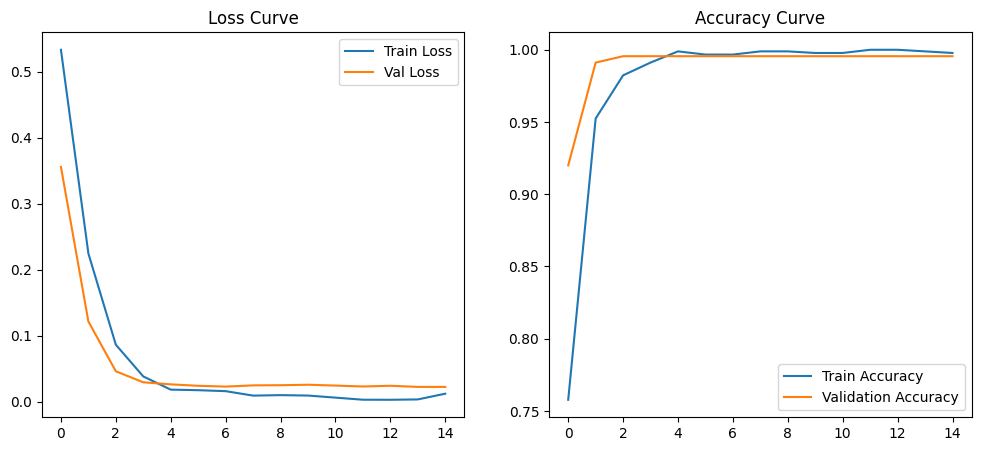

In [3]:
# -------------------------------------------------------
# Training Parameters
# -------------------------------------------------------

DATA_DIR = "dataset_binary"   # folder containing train/ and val/
IMG_SIZE = 192
BATCH_SIZE = 32
LR = 1e-4
EPOCHS = 15
NUM_CLASSES = 2  # turtle / nothing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------------------------------
# Data Augmentation & Dataset Loading
# -------------------------------------------------------

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Detected classes:", train_dataset.classes)

# -------------------------------------------------------
# Model: EfficientNet-B0
# -------------------------------------------------------

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Replace final layer with binary output
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# -------------------------------------------------------
# Training Loop
# -------------------------------------------------------

train_losses, val_losses = [], []
train_accs, val_accs = [], []

start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    running_corrects = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_corrects += (outputs.argmax(1) == labels).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_acc = running_corrects / len(train_dataset)

    # --- Validation ---
    model.eval()
    val_running_loss = 0
    val_running_corrects = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            val_running_corrects += (outputs.argmax(1) == labels).sum().item()

    val_loss = val_running_loss / len(val_dataset)
    val_acc = val_running_corrects / len(val_dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"[Epoch {epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.3f}")

# -------------------------------------------------------
# Save Model
# -------------------------------------------------------

torch.save(model.state_dict(), "turtle_classifier.pth")
print("\nModel saved as turtle_classifier.pth")
print("Total training time:", round((time.time() - start_time) / 60, 2), "minutes")

# -------------------------------------------------------
# Plot Training Curves
# -------------------------------------------------------

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

#### Discussion of training results (binary classifier)

The loss curves show a rapid decrease for both training and validation sets, stabilizing at very low values.  
Accuracy quickly reaches ~99% and stays high for both train and validation, with only a small gap between them.

Overall, the model converges well and generalizes correctly on the validation set.  
Such high performance may indicate that the **turtle vs nothing** task is relatively easy on these tiles (clear visual difference), but it also means our pipeline (tiling + augmentation + training) works as intended.


### Visualisation of the prediction

Found 4 tiles



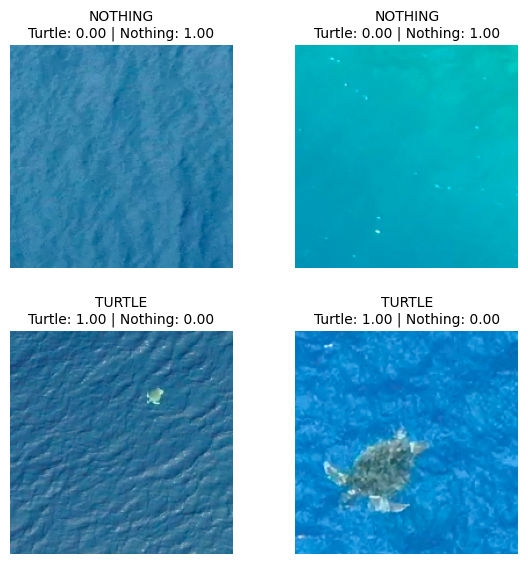

In [5]:
# -------------------------------------------------------
# Visualization of Predictions (Turtle vs Nothing) – 4 Tiles
# -------------------------------------------------------

MODEL_PATH = "turtle_classifier.pth"
IMG_SIZE = 192
INPUT_PATH = "TilesVisualisation"   # folder or single file

CLASSES = ["nothing", "turtle"]     # order must match training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -------------------------------------------------------
# Transform
# -------------------------------------------------------

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])


# -------------------------------------------------------
# Load Model
# -------------------------------------------------------

def load_model():
    model = models.efficientnet_b0(weights=None)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(CLASSES))
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
    model.eval()
    return model


# -------------------------------------------------------
# Predict Tile
# -------------------------------------------------------

def predict_tile(model, img_path):
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

    pred = CLASSES[probs.argmax()]
    return img, pred, probs


# -------------------------------------------------------
# Display one tile on a given axis
# -------------------------------------------------------

def show_prediction(ax, img, pred, probs):
    ax.imshow(img)
    ax.axis("off")

    title = (
        f"{pred.upper()}\n"
        f"Turtle: {probs[1]:.2f} | Nothing: {probs[0]:.2f}"
    )
    ax.set_title(title, fontsize=10)


# -------------------------------------------------------
# Grid Visualization (exactly up to 4 tiles)
# -------------------------------------------------------

def visualize_predictions(path=INPUT_PATH, max_images=4):
    model = load_model()

    # Case: single file
    if os.path.isfile(path):
        img, pred, probs = predict_tile(model, path)
        fig, ax = plt.subplots(figsize=(4, 4))
        show_prediction(ax, img, pred, probs)
        plt.tight_layout()

        # --- center in notebook ---
        buf = io.BytesIO()
        fig.savefig(buf, format="png", bbox_inches="tight")
        buf.seek(0)
        b64 = base64.b64encode(buf.read()).decode("utf-8")
        html = f"<div style='text-align:center;'><img src='data:image/png;base64,{b64}'/></div>"
        display(HTML(html))
        plt.close(fig)
        return

    # Folder case
    files = [f for f in os.listdir(path)
             if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    print(f"Found {len(files)} tiles")

    files = files[:max_images]

    fig, axes = plt.subplots(2, 2, figsize=(6, 6))
    axes = axes.flatten()

    for ax, fname in zip(axes, files):
        img_path = os.path.join(path, fname)
        img, pred, probs = predict_tile(model, img_path)
        show_prediction(ax, img, pred, probs)

    # Hide empty axes if < 4 images
    for ax in axes[len(files):]:
        ax.axis("off")

    plt.tight_layout(pad=2.0)

    # --- center the whole figure in the output cell ---
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    b64 = base64.b64encode(buf.read()).decode("utf-8")
    html = f"<div style='text-align:center;'><img src='data:image/png;base64,{b64}'/></div>"
    display(HTML(html))
    plt.close(fig)



# -------------------------------------------------------
# Run
# -------------------------------------------------------

visualize_predictions(INPUT_PATH, max_images=4)


#### Visual inspection of predictions (binary classifier)

The four example tiles confirm that the model correctly separates **turtle** and **nothing**:

- both water-only tiles are predicted as *nothing* with very high confidence,
- both tiles containing a turtle (including a small, distant one) are classified as *turtle* with confidence 1.00.

These qualitative results are consistent with the metrics: the model is not only accurate on aggregate statistics, but also visually makes sensible, confident predictions on individual tiles.


## Multi-Class Classification: Turtle vs Debris vs Nothing
In this section, we extend our classification pipeline to three categories: **sea turtles**, **marine debris**, and **empty-water tiles**.  
This multi-class model allows the network to distinguish wildlife from pollution and from background water, enabling a more complete analysis of drone imagery.


### Image Tiling for the debris

In [ ]:
# -------------------------------------------------------
# Tiling Script for Debris Images (192×192)
# -------------------------------------------------------

# Input folder: large debris images
INPUT_DIR = "debris_raw"        # e.g., 1920x1080 drone images

# Output folder: 192×192 debris tiles
OUTPUT_DIR = "debris_tiles"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------------------------------------------
# Tile parameters
# -------------------------------------------------------

TILE_SIZE = 192
OVERLAP = 0.30       # 30% tile overlap
stride = int(TILE_SIZE * (1 - OVERLAP))

# Filtering thresholds (optional but useful)
BRIGHTNESS_THRESHOLD = 10
MIN_VARIANCE = 15


# -------------------------------------------------------
# Helper: discard useless tiles
# -------------------------------------------------------

def is_useful_tile(tile: Image.Image) -> bool:
    """
    Returns False if the tile is too dark or too uniform.
    Lightweight filtering to avoid generating empty water-only tiles.
    """
    tile_np = np.array(tile.convert("L"))  # grayscale

    if tile_np.mean() < BRIGHTNESS_THRESHOLD:
        return False

    if tile_np.var() < MIN_VARIANCE:
        return False

    return True


# -------------------------------------------------------
# Generate tiles from a single image
# -------------------------------------------------------

def tile_image(image_path: str) -> int:
    img = Image.open(image_path)
    w, h = img.size

    base_name = os.path.splitext(os.path.basename(image_path))[0]
    saved = 0

    for y in range(0, h - TILE_SIZE + 1, stride):
        for x in range(0, w - TILE_SIZE + 1, stride):

            tile = img.crop((x, y, x + TILE_SIZE, y + TILE_SIZE))

            # Skip bad tiles
            if not is_useful_tile(tile):
                continue

            tile_name = f"{base_name}_x{x}_y{y}.png"
            tile_path = os.path.join(OUTPUT_DIR, tile_name)
            tile.save(tile_path, quality=95)

            saved += 1

    return saved


# -------------------------------------------------------
# Run tiling on all images in the folder
# -------------------------------------------------------

files = [f for f in os.listdir(INPUT_DIR)
         if f.lower().endswith((".jpg", ".jpeg", ".png"))]

total_tiles = 0

print(f"--- Starting debris tiling ({len(files)} images) ---")

for filename in files:
    path = os.path.join(INPUT_DIR, filename)
    n = tile_image(path)
    total_tiles += n
    print(f"{filename} → {n} tiles")

print("\n--- Tiling complete ---")
print("Total tiles generated:", total_tiles)
print("Saved to:", OUTPUT_DIR)


#### Note on the Tiling Step

The tiling script shown in this notebook is **not executed here**, as the tiling process was performed beforehand.  
Since tiling large drone images generates thousands of 192×192 tiles, running it directly inside the notebook would be time-consuming and unnecessary.

The code is included **for documentation and reproducibility**, but the dataset used in the following sections was already pre-generated.


For the debris, here is an example of what the manual selection process looks like in practice.

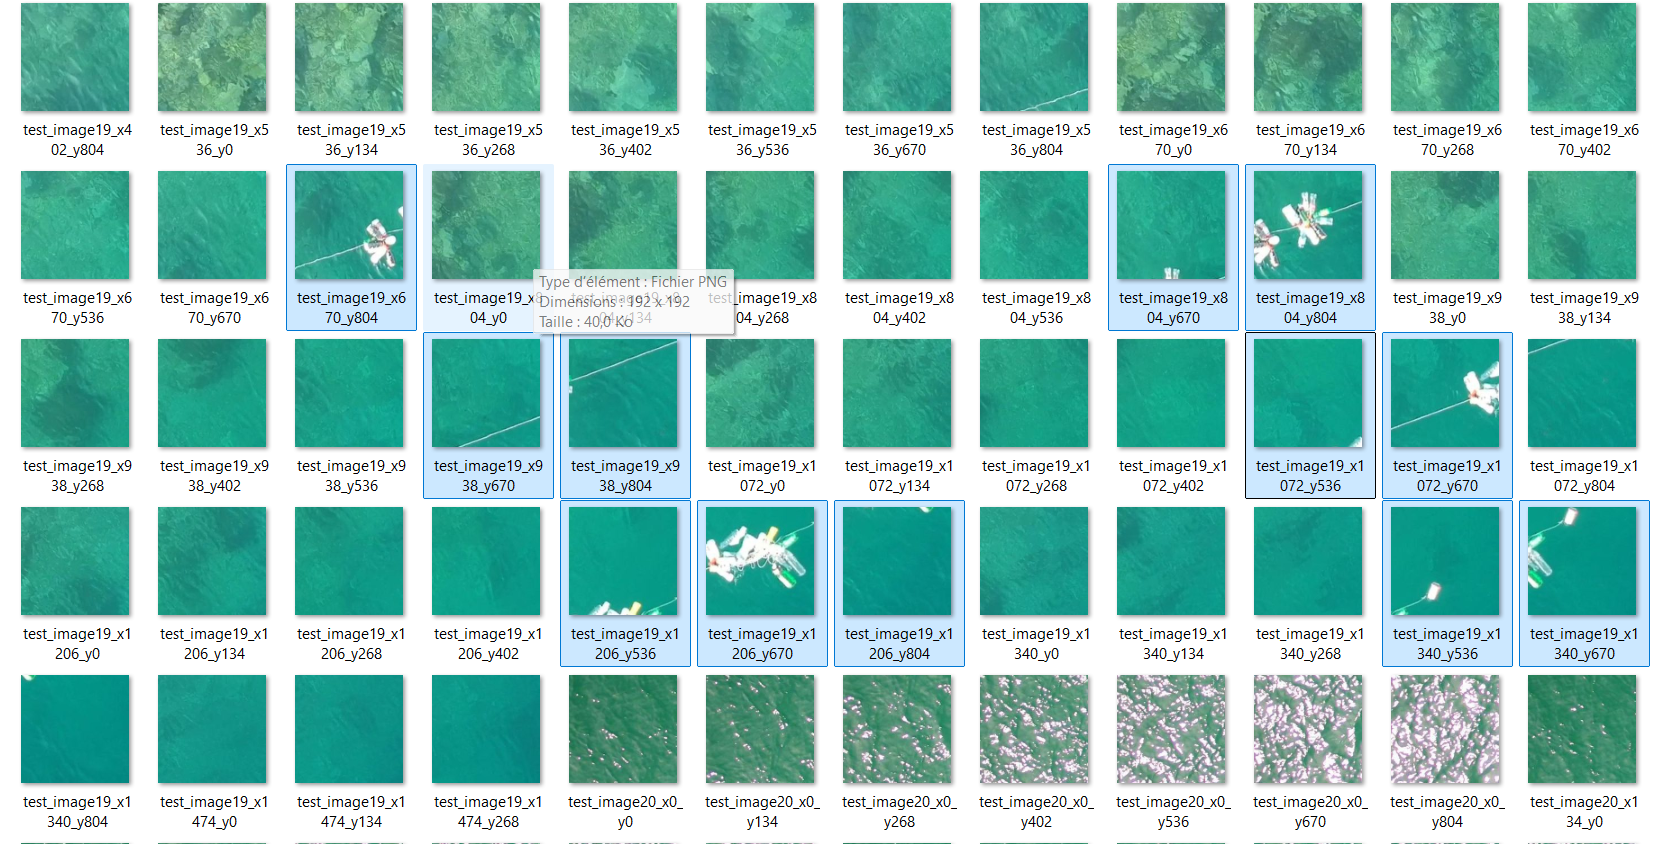

In [3]:
Image("im2.png")

### DataSet Preparation

In [15]:
# -------------------------------------------------------
# Dataset Split: Train / Validation (3 classes)
# -------------------------------------------------------

SOURCE_DIR = r"C:\Users\alial\OneDrive\Bureau\GreenAIprojectV2"
OUTPUT_DIR = r"C:\Users\alial\OneDrive\Bureau\GreenAIprojectV2\dataset"

CLASSES = ["turtle", "nothing", "debris"]   # your 3 classes
VAL_RATIO = 0.20                             # 20% validation split


# -------------------------------------------------------
# Create folder tree
# -------------------------------------------------------

def create_folders():
    for split in ["train", "val"]:
        for cls in CLASSES:
            folder = os.path.join(OUTPUT_DIR, split, cls)
            os.makedirs(folder, exist_ok=True)


# -------------------------------------------------------
# Random train/val split per class
# -------------------------------------------------------

def split_dataset():
    for cls in CLASSES:
        class_dir = os.path.join(SOURCE_DIR, cls)

        images = [
            f for f in os.listdir(class_dir)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]

        random.shuffle(images)  # random order

        n_total = len(images)
        n_val = int(n_total * VAL_RATIO)

        val_images = images[:n_val]
        train_images = images[n_val:]

        print(f"\nClass '{cls}': {n_total} images → "
              f"{len(train_images)} train, {len(val_images)} val")

        # Copy train images
        for img in train_images:
            shutil.copy(
                os.path.join(class_dir, img),
                os.path.join(OUTPUT_DIR, "train", cls, img)
            )

        # Copy validation images
        for img in val_images:
            shutil.copy(
                os.path.join(class_dir, img),
                os.path.join(OUTPUT_DIR, "val", cls, img)
            )


# -------------------------------------------------------
# Run split
# -------------------------------------------------------

create_folders()
split_dataset()

print("\nDataset ready for PyTorch in:", OUTPUT_DIR)


Class 'turtle': 534 images → 428 train, 106 val

Class 'nothing': 595 images → 476 train, 119 val

Class 'debris': 380 images → 304 train, 76 val

Dataset ready for PyTorch in: C:\Users\alial\OneDrive\Bureau\GreenAIprojectV2\dataset


#### Dataset Directory Structure
After splitting the dataset into training and validation sets, the directory structure should look like this:



In [ ]:
dataset/
│
├── train/
│ ├── turtle/
│ ├── debris/
│ └── nothing/
│
└── val/
├── turtle/
├── debris/
└── nothing/

#### 
Each folder contains the corresponding 192×192 image tiles.  
This structure is automatically created by the train/validation split script  
and is required by **PyTorch's `ImageFolder`**.

### Training a 3-Class Classifier (Turtle / Debris / Nothing)

This section extends the binary classifier to a **three-class model**.  
The overall training pipeline (data loading, augmentation, training loop) is the same as before,  
but a few key differences are required:

- The dataset directory now contains **three folders** instead of two.
- The final classification layer of EfficientNet-B0 is replaced with a layer of size **3**.
- `ImageFolder` automatically assigns labels based on folder names (turtle / debris / nothing).
- The loss, accuracy, and metrics are now computed over three classes.

Apart from these modifications, the training loop and the evaluation logic remain unchanged.  
The model is saved as `classifier_3classes.pth` for later inference.


Using device: cpu
Found classes: ['debris', 'nothing', 'turtle']
[Epoch 1/15] Train Loss: 0.7956 | Train Acc: 0.701 | Val Loss: 0.4732 | Val Acc: 0.914
[Epoch 2/15] Train Loss: 0.2877 | Train Acc: 0.939 | Val Loss: 0.1409 | Val Acc: 0.983
[Epoch 3/15] Train Loss: 0.0951 | Train Acc: 0.984 | Val Loss: 0.0669 | Val Acc: 0.990
[Epoch 4/15] Train Loss: 0.0467 | Train Acc: 0.991 | Val Loss: 0.0405 | Val Acc: 0.990
[Epoch 5/15] Train Loss: 0.0267 | Train Acc: 0.994 | Val Loss: 0.0339 | Val Acc: 0.990
[Epoch 6/15] Train Loss: 0.0197 | Train Acc: 0.998 | Val Loss: 0.0265 | Val Acc: 0.990
[Epoch 7/15] Train Loss: 0.0209 | Train Acc: 0.993 | Val Loss: 0.0267 | Val Acc: 0.997
[Epoch 8/15] Train Loss: 0.0286 | Train Acc: 0.993 | Val Loss: 0.0211 | Val Acc: 0.997
[Epoch 9/15] Train Loss: 0.0128 | Train Acc: 0.996 | Val Loss: 0.0233 | Val Acc: 0.993
[Epoch 10/15] Train Loss: 0.0098 | Train Acc: 0.999 | Val Loss: 0.0199 | Val Acc: 0.997
[Epoch 11/15] Train Loss: 0.0199 | Train Acc: 0.995 | Val Loss: 

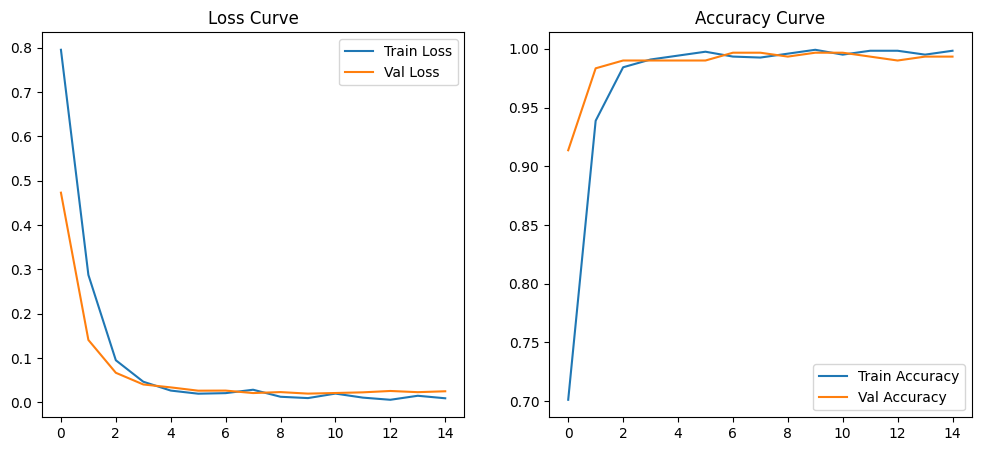

In [16]:
# -------------------------------------------------------
# Training Script for 3-Class Classification
# Classes: turtle / debris / nothing
# -------------------------------------------------------

# -------------------------------------------------------
# Training parameters
# -------------------------------------------------------

DATA_DIR = "dataset"       # folder containing train/ and val/
IMG_SIZE = 192
BATCH_SIZE = 32
LR = 1e-4
EPOCHS = 15
NUM_CLASSES = 3            # turtle, debris, nothing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------------------------------
# Data augmentation
# -------------------------------------------------------

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Found classes:", train_dataset.classes)

# -------------------------------------------------------
# Model: EfficientNet-B0
# -------------------------------------------------------

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Replace classification layer with 3-class output
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# -------------------------------------------------------
# Training loop
# -------------------------------------------------------

train_losses, val_losses = [], []
train_accs, val_accs = [], []

start_time = time.time()

for epoch in range(EPOCHS):

    # --- Training ---
    model.train()
    running_loss = 0
    running_corrects = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_corrects += (outputs.argmax(1) == labels).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_acc = running_corrects / len(train_dataset)

    # --- Validation ---
    model.eval()
    val_loss_total = 0
    val_corrects = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss_total += loss.item() * images.size(0)
            val_corrects += (outputs.argmax(1) == labels).sum().item()

    val_loss = val_loss_total / len(val_dataset)
    val_acc = val_corrects / len(val_dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"[Epoch {epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.3f}")

# -------------------------------------------------------
# Save model
# -------------------------------------------------------

torch.save(model.state_dict(), "classifier_3classes.pth")
print("\nModel saved as: classifier_3classes.pth")
print("Total time:", round((time.time() - start_time) / 60, 2), "minutes")

# -------------------------------------------------------
# Plot curves
# -------------------------------------------------------

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

#### Interpretation of Training Results (3-Class Classifier)

The model reaches **very high accuracy (>99%)** on both training and validation sets.  
The **loss curves decrease smoothly**, and the **train/validation curves remain close**, indicating that:

- The model learns quickly and efficiently.
- There is **no significant overfitting** (validation accuracy matches training accuracy).
- The dataset is well-balanced after tiling and augmentation.
- EfficientNet-B0 handles the 3-class classification task extremely well.

Overall, these results show that the classifier successfully distinguishes **turtle / debris / nothing** tile categories with excellent stability.


### Visualisation of the prediction

After training the multi-class classifier (turtle / debris / nothing), we can apply it to 
individual 192×192 tiles to inspect its behavior.  
The goal of this section is to **load the trained model**, apply it to a set of tiles, and  
**display the predictions together with their confidence scores**.

Compared to the 2-class version, only a few elements change:

- the model now outputs **three probabilities** (one per class),
- the class list must match the folder structure used during training,
- the visualization displays all three scores under each tile.

To make the output easy to interpret in a notebook, several tiles are shown in a **grid layout**, 
each with:
- the predicted class,
- the three class probabilities,
- and the original tile image.

This allows you to quickly verify how well the model distinguishes turtles, debris, and empty-water tiles.


Found 6 tiles



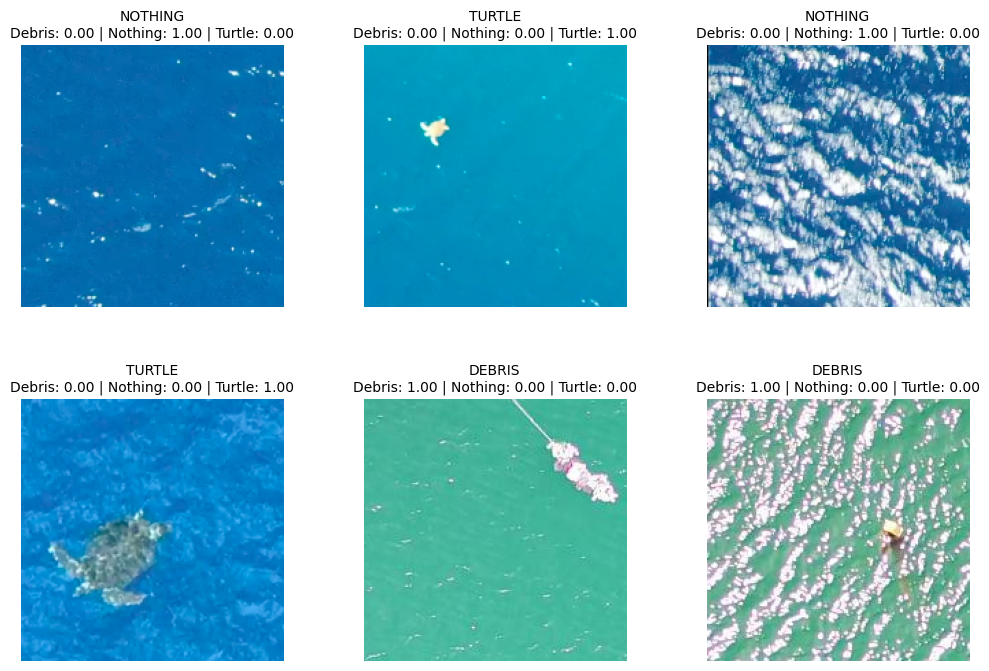

In [7]:
# -------------------------------------------------------
# Visualization of Predictions (3 Classes) - Centered Grid
# -------------------------------------------------------

import os
import io
import base64

import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import HTML, display

MODEL_PATH = "classifier_3classes.pth"
IMG_SIZE = 192
INPUT_PATH = "TilesVisualisationV2"   # Folder or single image

# IMPORTANT: must match train_dataset.classes order
CLASSES = ["debris", "nothing", "turtle"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------------------------------
# Transform
# -------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])


# -------------------------------------------------------
# Load Model
# -------------------------------------------------------
def load_model():
    model = models.efficientnet_b0(weights=None)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(CLASSES))
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
    model.eval()
    return model


# -------------------------------------------------------
# Predict a tile
# -------------------------------------------------------
def predict_tile(model, img_path):
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

    pred = CLASSES[probs.argmax()]
    return img, pred, probs


# -------------------------------------------------------
# Display prediction on an axis
# -------------------------------------------------------
def show_prediction(ax, img, pred, probs):
    ax.imshow(img)
    ax.axis("off")

    # Build a consistent line: "Debris: 0.01 | Nothing: 0.98 | Turtle: 0.01"
    prob_text = " | ".join(
        f"{cls.capitalize()}: {probs[i]:.2f}"
        for i, cls in enumerate(CLASSES)
    )

    ax.set_title(f"{pred.upper()}\n{prob_text}", fontsize=10, pad=6)


# -------------------------------------------------------
# Helper: display a matplotlib figure centered in the notebook
# -------------------------------------------------------
def display_centered(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    encoded = base64.b64encode(buf.read()).decode("utf-8")
    html = f"<div style='text-align:center;'><img src='data:image/png;base64,{encoded}'></div>"
    display(HTML(html))
    plt.close(fig)


# -------------------------------------------------------
# Visualize up to 6 tiles in a centered 2x3 grid
# -------------------------------------------------------
def visualize_predictions(path=INPUT_PATH, max_images=6):
    model = load_model()

    # --- Single file case ---
    if os.path.isfile(path):
        img, pred, probs = predict_tile(model, path)
        fig, ax = plt.subplots(figsize=(4, 4))
        show_prediction(ax, img, pred, probs)
        display_centered(fig)
        return

    # --- Folder case ---
    files = sorted([
        f for f in os.listdir(path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ])

    print(f"Found {len(files)} tiles")

    files = files[:max_images]

    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    fig.patch.set_facecolor("white")
    fig.subplots_adjust(left=0.1, right=0.9, wspace=0.25, hspace=0.35)

    axes = axes.flatten()

    for ax, fname in zip(axes, files):
        img_path = os.path.join(path, fname)
        img, pred, probs = predict_tile(model, img_path)
        show_prediction(ax, img, pred, probs)

    # Hide unused axes if less than 6 tiles
    for ax in axes[len(files):]:
        ax.axis("off")

    # No plt.show() → we only show via HTML, centered
    display_centered(fig)


# -------------------------------------------------------
# Run Visualization
# -------------------------------------------------------

visualize_predictions(INPUT_PATH)


#### Interpretation of the 3-Class Predictions

The model correctly identifies all 6 tiles:

- **Turtle tiles** are classified with very high confidence (Turtle ≈ 1.00).
- **Debris tiles** are also robustly detected, even when shapes are small or partially visible.
- **Nothing tiles** (pure water) are consistently predicted as “Nothing” with confidence close to 1.00.

These results confirm that:
- The model is able to distinguish **turtles**, **floating debris**, and **empty water** even when visual differences are subtle.
- The tiling strategy produced good training samples.
- The classifier generalizes well on unseen tiles, with clear separation between the three classes.

Overall, this grid demonstrates strong real-world performance for the 3-class detector.


## Conclusion

In this work, we developed a complete pipeline for detecting **sea turtles**, **floating debris**, and **empty water areas** from aerial drone imagery.  
Through tiling, data augmentation, and transfer learning with EfficientNet-B0, the model achieved strong accuracy across all three classes and demonstrated reliable performance on unseen tiles.

This approach highlights the potential of lightweight, tile-based classification models for **marine conservation and environmental monitoring**.  
Such a system could support real-world applications like:

- **Automated marine wildlife surveys** using drones  
- **Detection of pollution hotspots** such as floating plastics or fishing gear  
- **Early-warning tools** for conservation teams  
- **Assistance to UAV operators** by prioritizing regions containing animals or debris  

Overall, this project provides a solid foundation for scalable, AI-assisted monitoring of marine environments.
